In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

import pickle as pkl
from collections import Counter

from haplm.hap_util import mat_by_marker, num_to_str, str_to_num
from sim_data import parse_sim_data

In [2]:
n_datasets = 100
n_pools = 20
n_markers = 8
pool_size = 50

In [3]:
def get_pmean(idata):
    return idata.posterior.p.values.mean(axis=(0,1))

def get_pess(idata):
    return az.ess(idata, var_names=['p'])['p'].values

def dataset_to_dict(dataset):
    d = dataset.to_dict()
    output = d['attrs'].copy()
    for name, info in d['data_vars'].items():
        output[name] = info['data']
    return output

def get_walltime(smpl_stat_dict):
    if 'preprocess_time' not in smpl_stat_dict:
        return np.array(smpl_stat_dict['time_incl_tune']).sum()
    
    return smpl_stat_dict['preprocess_time'] + smpl_stat_dict['mcmc_walltime']

def get_tvd(ptrue, pest):
    return 0.5*(ptrue.sub(pest, fill_value=0).abs().sum())

def get_ess(ptrue, haps, ess):
    return [val for hnum, val in zip(haps, ess) if num_to_str(hnum, n_markers) in ptrue.index]

def make_series(arr, hnums, n_markers):
    return pd.Series(arr, index=[num_to_str(hnum, n_markers) for hnum in hnums])

In [4]:
from matplotlib import rc, rcParams
rc('font', **{'family': 'serif', 'serif': ['Palatino']})
rc('text', usetex = True)
rc('font', size=14)

# colors for plotting
colors = [
    '#1b9e77',
    '#d95f02',
    '#7570b3',
    '#e7298a',
    '#66a61e',
    '#e6ab02'
]

In [5]:
ptrue_list = []
for i in range(n_datasets):
    ds_idx = i + 1
    fn_prefix = f'../../data/encode/psize{pool_size}_m{n_markers}_id{ds_idx}'
    with open(f'{fn_prefix}.prob') as fp:
        ptrue = pd.Series({line.split()[0]: float(line.split()[1]) for line in fp})
    ptrue_list.append(ptrue)

haps_list = []
pl_coverage = []
ehaps_list = []
amats = []
with open('../../data/encode/PL_aeml.txt') as fp:
    for i, line in enumerate(fp):
        haps = [int(x) for x in line.split()]
        haps_list.append(haps)
        ehaps_list.append(set(ptrue_list[i].index) - {num_to_str(hap, n_markers) for hap in haps})
        pl_coverage.append(sum(ptrue_list[i].get(num_to_str(hap, n_markers), 0) for hap in haps))
        amats.append(np.array([[(hnum >> m) & 1 for hnum in haps] for m in range(n_markers)]))
        
# number of datasets where PL (subroutine is AEML) finds all true haplotypes
print(sum(len(ehaps) == 0 for ehaps in ehaps_list))
print(1-np.mean(pl_coverage))

31
0.011842105263157765


In [6]:
ptrue_list = []
for i in range(n_datasets):
    ds_idx = i + 1
    fn_prefix = f'../../data/encode/psize{pool_size}_m{n_markers}_id{ds_idx}'
    with open(f'{fn_prefix}.prob') as fp:
        ptrue = pd.Series({line.split()[0]: float(line.split()[1]) for line in fp})
    ptrue_list.append(ptrue)

haps_list = []
pl_coverage = []
ehaps_list = []
amats = []
with open('../../data/encode/PL_mn_approx.txt') as fp:
    for i, line in enumerate(fp):
        haps = [int(x) for x in line.split()]
        haps_list.append(haps)
        ehaps_list.append(set(ptrue_list[i].index) - {num_to_str(hap, n_markers) for hap in haps})
        pl_coverage.append(sum(ptrue_list[i].get(num_to_str(hap, n_markers), 0) for hap in haps))
        amats.append(np.array([[(hnum >> m) & 1 for hnum in haps] for m in range(n_markers)]))

# number of datasets where PL (subroutine is LC-Sampling) finds all true haplotypes
print(sum(len(ehaps) == 0 for ehaps in ehaps_list), len(haps_list))
print(1-np.mean(pl_coverage))

43 100
0.006631578947368322


## Inference results

In [7]:
# init stats
stats = [{} for _ in range(n_datasets)]

In [8]:
# get stats from MCMC results (Bayesian)
for method in ['mn_approx', 'cgibbs', 'hippo']:
    print(method, end=' ')
    for i in range(n_datasets):
        print(i+1, end=' ')
        stats_dict = stats[i]
        fn_prefix = f'../../data/encode/psize{pool_size}_m{n_markers}_id{i+1}'    
        H = len(haps_list[i])

        idata = az.from_netcdf(f'{fn_prefix}_{method}.netcdf')
        
        if 'hippo' in method:
            haps = list(range(2**n_markers))
        else:
            haps = haps_list[i]
        
        pmean = make_series(get_pmean(idata), haps, n_markers)
        
        ptrue = np.array([ptrue_list[i].get(num_to_str(hnum, n_markers), 0) for hnum in haps])
        quants = (np.vstack(idata.posterior.p) < ptrue).mean(axis=0)

        stats_dict[method] = {'pmean': pmean, # posterior mean
                              'qs': quants, # quantiles
                              'pess': get_pess(idata), # ESS of p
                              'sample_stats': dataset_to_dict(idata.sample_stats) # timings
                             }
    print()

mn_approx 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
cgibbs 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
hippo 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 


In [9]:
# get stats from AEML
for i in range(n_datasets):
    fn = f'../../data/encode/psize{pool_size}_m{n_markers}_id{i+1}_aeml.pkl'            
    with open(fn, 'rb') as fp:
        stats[i]['AEML'] = pkl.load(fp)
        stats[i]['AEML']['pseries'] = make_series(stats[i]['AEML']['pest'], haps_list[i], n_markers)

In [10]:
# average time used by AEML per dataset
sum(sdict['AEML']['time'] for sdict in stats)/100

12.273486540317535

The author of HIPPO suggests to use the chain with the highest average log posterior. We check that this does not improve the total variation distance (TVD) of the posterior mean from the true frequencies.

In [11]:
# get stats from 'best' chain of hippo
pmean_best_arr = []
haps = list(range(2**n_markers))
for i in range(n_datasets):
    idata = az.from_netcdf(f'../../data/encode/psize{pool_size}_m{n_markers}_id{i+1}_hippo.netcdf')          
    c = idata.sample_stats.avg_logpost.values.argmax()
    pmean_best_arr.append(make_series(idata.posterior.p.values[c].mean(axis=0), haps, n_markers))    

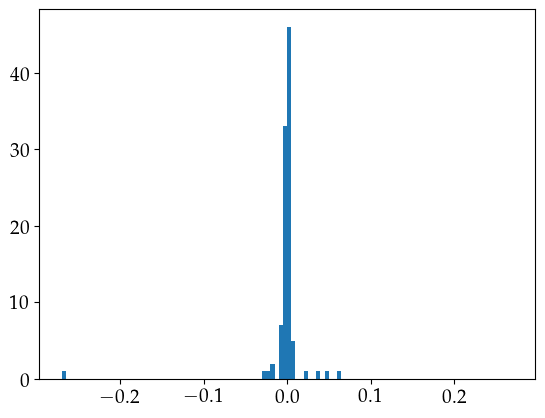

In [12]:
# TVD for <HIPPO all chains> - TVD for <HIPPO best chain>
# positive values means <HIPPO all chains> is worse than <HIPPO best chain>
diffs = []
for i in range(n_datasets):
    all_chains_tvd = get_tvd(stats[i]['hippo']['pmean'], ptrue_list[i])
    best_chain_tvd = get_tvd(pmean_best_arr[i], ptrue_list[i])
    diffs.append(all_chains_tvd - best_chain_tvd)
bd = (int(max(abs(min(diffs)), abs(max(diffs))) * 100) + 1) * 0.01
plt.hist(diffs, bins=np.arange(-bd, bd+1e-4, 5e-3));

## ESS and TVD

In [13]:
cgibbs_tvd = np.array([get_tvd(ptrue_list[i], stats[i]['cgibbs']['pmean']) for i in range(n_datasets)])
mn_tvd = np.array([get_tvd(ptrue_list[i], stats[i]['mn_approx']['pmean']) for i in range(n_datasets)])
hippo_tvd = np.array([get_tvd(ptrue_list[i], stats[i]['hippo']['pmean']) for i in range(n_datasets)])
aeml_tvd = np.array([get_tvd(ptrue_list[i], stats[i]['AEML']['pseries']) for i in range(n_datasets)])

In [14]:
tvd_plot = [mn_tvd, cgibbs_tvd, aeml_tvd, hippo_tvd]

In [15]:
cgibbs_ess_all = np.concatenate([stats[i]['cgibbs']['pess'] for i in range(n_datasets)])
mn_ess_all = np.concatenate([stats[i]['mn_approx']['pess'] for i in range(n_datasets)])
# hippo_ess_all = np.concatenate([stats[i]['hippo']['pess'] for i in range(n_datasets)])
hippo_ess_all = np.concatenate([stats[i]['hippo']['pess'][haps_list[i]] for i in range(n_datasets)])

In [16]:
cgibbs_mean_all = np.concatenate([stats[i]['cgibbs']['pmean'] for i in range(n_datasets)])
mn_mean_all = np.concatenate([stats[i]['mn_approx']['pmean'] for i in range(n_datasets)])
hippo_mean_all = np.concatenate([stats[i]['hippo']['pmean'] for i in range(n_datasets)])

In [17]:
ess_plot = [mn_ess_all, cgibbs_ess_all, hippo_ess_all]

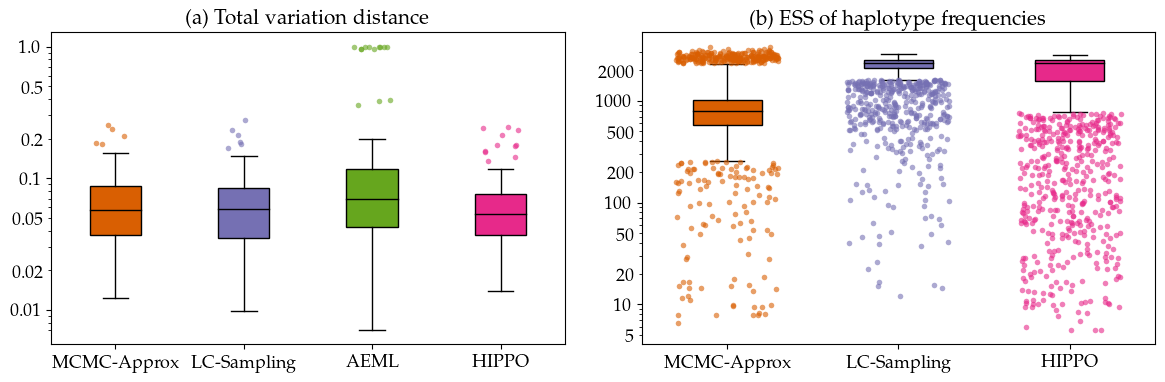

In [18]:
np.random.seed(1)
fig, axes = plt.subplots(figsize=(12,4), ncols=2)

ax = axes[0]
for i in range(4):
    colors_sub = [colors[j] for j in [1, 2, 4, 3]]
    b = ax.boxplot([tvd_plot[i]], positions=[i], widths=[0.4],
                   patch_artist=True, boxprops=dict(facecolor=colors_sub[i]),
                   flierprops=dict(marker='o', markersize=4, markerfacecolor=colors_sub[i],
                                   markeredgecolor='none', alpha=0.6),
                   medianprops=dict(color='k'))
    outliers = b['fliers'][0].get_data()
    jittered = outliers[0] + np.random.uniform(-0.15, 0.15, len(outliers[0]))
    b['fliers'][0].set_data((jittered, outliers[1]))

ax.set_yscale('log')
ax.set_yticks([0.01,0.1,1.0], [0.01,0.1,1.0], fontsize=13)
ax.set_yticks(np.concatenate([np.arange(7e-3,1e-2,1e-3),
                              np.arange(2e-2, 1e-1, 1e-2),
                              np.arange(0.2, 1, 0.1)]),
            ['']*3 + ['0.02'] + ['']*2 + ['0.05'] + ['']*4 + ['0.2'] + ['']*2 + ['0.5'] + ['']*4,
            minor=True, fontsize=13)
ax.set_xticks(np.arange(4), ['MCMC-Approx', 'LC-Sampling', 'AEML', 'HIPPO'], fontsize=13);
ax.set_title('(a) Total variation distance', fontsize=15)

ax = axes[1]
colors_sub = [colors[j] for j in [1, 2, 3]]

# for i in range(3):
#     b = ax.boxplot([np.log10(ess_plot[i])], positions=[i], widths=[0.4],
#                    patch_artist=True, boxprops=dict(facecolor=colors_sub[i]),
#                    flierprops=dict(markersize=0, markeredgecolor='none'),
#                    medianprops=dict(color='k'))
#     outliers = b['fliers'][0].get_data()[1]
#     outliers_dict = Counter((outliers // 0.1).astype(int))
#     # print(sorted(outliers_dict))
#     for val, ct in outliers_dict.items():
#         ax.scatter(np.arange(-0.016*(ct-1), 0.016*(ct-1)+0.001, 0.032) + i, [0.1*val]*ct, 
#                    color=colors_sub[i], s=5)
        
for i in range(3):
    b = ax.boxplot([np.log10(ess_plot[i])], positions=[i], widths=[0.4],
                   patch_artist=True, boxprops=dict(facecolor=colors_sub[i]),
                   flierprops=dict(marker='o', markersize=4, markerfacecolor=colors_sub[i],
                                   markeredgecolor='none', alpha=0.6),
                   medianprops=dict(color='k'))
    outliers = b['fliers'][0].get_data()
    jittered = outliers[0] + np.random.uniform(-0.3, 0.3, len(outliers[0]))
    b['fliers'][0].set_data((jittered, outliers[1]))
ax.set_yticks([1,2,3],[10,100,1000], fontsize=13)
ax.set_yticks(np.log10(np.concatenate([np.arange(5,10),
                                       np.arange(20,100,10),
                                       np.arange(200,1000,100),
                                       np.arange(2000,4000,1000)])),
              ['5'] + ['']*4 + ['20'] + ['']*2 + ['50'] + ['']*4 + ['200'] + ['']*2 + ['500'] + ['']*4 + ['2000', ''],
              minor=True, fontsize=13)
ax.set_xticks(np.arange(3), ['MCMC-Approx', 'LC-Sampling', 'HIPPO'], fontsize=13);
ax.set_title(r'(b) ESS of haplotype frequencies', fontsize=15)
plt.subplots_adjust(top=0.9, left=0.05, right=0.97, bottom=0.12, wspace=0.15);
plt.savefig('kgenomes_tvd_ess.png', dpi=300, facecolor='white');

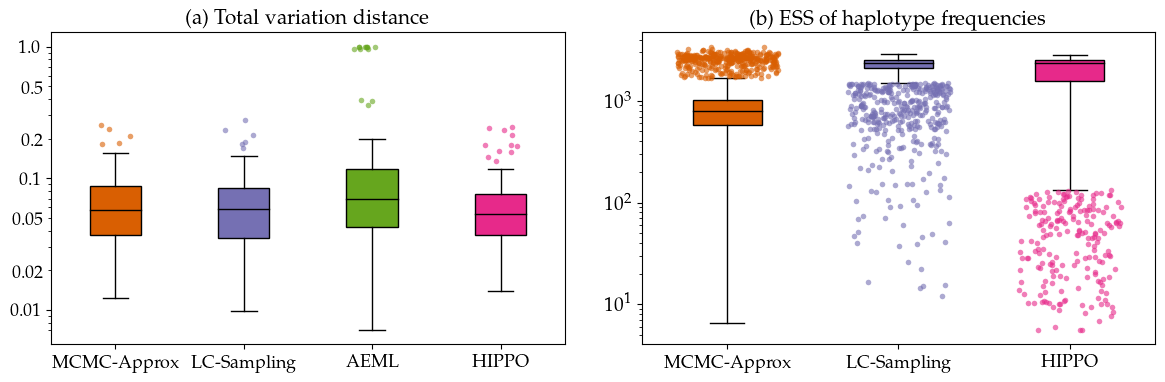

In [19]:
np.random.seed(2023)
fig, axes = plt.subplots(figsize=(12,4), ncols=2)

ax = axes[0]
for i in range(4):
    colors_sub = [colors[j] for j in [1, 2, 4, 3]]
    b = ax.boxplot([tvd_plot[i]], positions=[i], widths=[0.4],
                   patch_artist=True, boxprops=dict(facecolor=colors_sub[i]),
                   flierprops=dict(marker='o', markersize=4, markerfacecolor=colors_sub[i],
                                   markeredgecolor='none', alpha=0.6),
                   medianprops=dict(color='k'))
    outliers = b['fliers'][0].get_data()
    jittered = outliers[0] + np.random.uniform(-0.15, 0.15, len(outliers[0]))
    b['fliers'][0].set_data((jittered, outliers[1]))

ax.set_yscale('log')
ax.set_yticks([0.01,0.1,1.0], [0.01,0.1,1.0], fontsize=13)
ax.set_yticks(np.concatenate([np.arange(7e-3,1e-2,1e-3),
                              np.arange(2e-2, 1e-1, 1e-2),
                              np.arange(0.2, 1, 0.1)]),
            ['']*3 + ['0.02'] + ['']*2 + ['0.05'] + ['']*4 + ['0.2'] + ['']*2 + ['0.5'] + ['']*4,
            minor=True, fontsize=13)
ax.set_xticks(np.arange(4), ['MCMC-Approx', 'LC-Sampling', 'AEML', 'HIPPO'], fontsize=13);
ax.set_title('(a) Total variation distance', fontsize=15)

ax = axes[1]
colors_sub = [colors[j] for j in [1, 2, 3]]

for i in range(3):
    b = ax.boxplot([ess_plot[i]], positions=[i], widths=[0.4],
                   patch_artist=True, boxprops=dict(facecolor=colors_sub[i]),
                   flierprops=dict(marker='o', markersize=4, markerfacecolor=colors_sub[i],
                                   markeredgecolor='none', alpha=0.6),
                   medianprops=dict(color='k'))
    outliers = b['fliers'][0].get_data()
    jittered = outliers[0] + np.random.uniform(-0.3, 0.3, len(outliers[0]))
    b['fliers'][0].set_data((jittered, outliers[1]))
ax.set_yscale('log')
        
# for i in range(3):
#     b = ax.boxplot([np.log10(ess_plot[i])], positions=[i], widths=[0.4],
#                    patch_artist=True, boxprops=dict(facecolor=colors_sub[i]),
#                    flierprops=dict(marker='o', markersize=4, markerfacecolor=colors_sub[i],
#                                    markeredgecolor='none', alpha=0.6),
#                    medianprops=dict(color='k'))
#     outliers = b['fliers'][0].get_data()
#     jittered = outliers[0] + np.random.uniform(-0.3, 0.3, len(outliers[0]))
#     b['fliers'][0].set_data((jittered, outliers[1]))
# ax.set_yticks([1,2,3],[10,100,1000], fontsize=13)
# ax.set_yticks(np.log10(np.concatenate([np.arange(5,10),
#                                        np.arange(20,100,10),
#                                        np.arange(200,1000,100),
#                                        np.arange(2000,4000,1000)])),
#               ['5'] + ['']*4 + ['20'] + ['']*2 + ['50'] + ['']*4 + ['200'] + ['']*2 + ['500'] + ['']*4 + ['2000', ''],
#               minor=True, fontsize=13)

ax.set_xticks(np.arange(3), ['MCMC-Approx', 'LC-Sampling', 'HIPPO'], fontsize=13);
ax.set_title(r'(b) ESS of haplotype frequencies', fontsize=15)
plt.subplots_adjust(top=0.9, left=0.05, right=0.97, bottom=0.12, wspace=0.15);
plt.savefig('kgenomes_tvd_ess.png', dpi=300, facecolor='white');

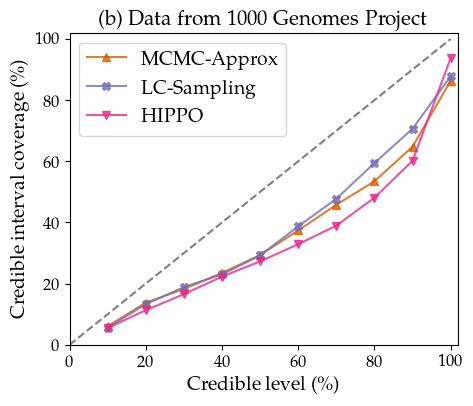

In [20]:
name_dict = {'mn_approx': 'MCMC-Approx',
             'cgibbs': 'LC-Sampling',
             'hippo': 'HIPPO'}
markers = '^Xv'
tmp_colors = [colors[i] for i in [1, 2, 3]]

plt.figure(figsize=(6*0.8, 5*0.8))
for j, method in enumerate(['mn_approx', 'cgibbs', 'hippo']):
    quants = []
    for i in range(n_datasets):
        if 'hippo' in method:
            haps = list(range(2**n_markers))
        else:
            haps = haps_list[i]
        tmp = [v for hnum, v in zip(haps, stats[i][method]['qs'])
               if num_to_str(hnum, n_markers) in ptrue_list[i].index]
               #and ptrue_list[i][num_to_str(hnum, n_markers)] > 0.01]
        #tmp = [v for v in stats[i][method]['qs']]
        tmp += [1]*(len(ptrue_list[i]) - len(tmp))
        quants += tmp
    
    quants = np.array(quants)
    alphas = np.arange(1, 11) / 10
    coverage = []
    for alpha in alphas:
        coverage.append((abs(quants - 0.5) < alpha/2).mean())
    plt.plot(alphas*100, 100*np.array(coverage), f'{markers[j]}-', alpha=0.8, color=tmp_colors[j],
             label=name_dict[method], markersize=6)
plt.plot([0,100], [0,100], '--', alpha=0.5, color='k')

plt.xlim((0,102))
plt.ylim((0,102))

plt.xlabel('Credible level (\%)', fontsize=14)
plt.ylabel('Credible interval coverage (\%)', fontsize=14)
plt.legend(fontsize=14);
plt.title('(b) Data from 1000 Genomes Project', fontsize=15);
plt.tick_params(axis='both', which='both', labelsize=12)

plt.subplots_adjust(top=0.92, left=0.15, right=0.96, bottom=0.14);
plt.savefig('kgenomes_coverage.png', dpi=200, facecolor='white');

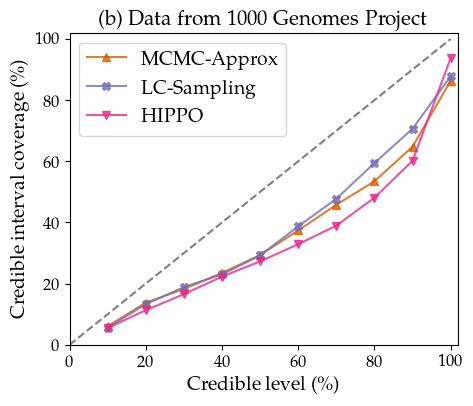

In [21]:
name_dict = {'mn_approx': 'MCMC-Approx',
             'cgibbs': 'LC-Sampling',
             'hippo': 'HIPPO'}
markers = '^Xv'
tmp_colors = [colors[i] for i in [1, 2, 3]]

plt.figure(figsize=(6*0.8, 5*0.8))
for j, method in enumerate(['mn_approx', 'cgibbs', 'hippo']):
    quants = []
    for i in range(n_datasets):
        if 'hippo' in method:
            haps = list(range(2**n_markers))
        else:
            haps = haps_list[i]
        tmp = [v for hnum, v in zip(haps, stats[i][method]['qs'])
               if num_to_str(hnum, n_markers) in ptrue_list[i].index]
               #and ptrue_list[i][num_to_str(hnum, n_markers)] > 0.01]
        #tmp = [v for v in stats[i][method]['qs']]
        tmp += [1]*(len(ptrue_list[i]) - len(tmp))
        quants += tmp
    
    quants = np.array(quants)
    alphas = np.arange(1, 11) / 10
    coverage = []
    for alpha in alphas:
        coverage.append((abs(quants - 0.5) < alpha/2).mean())
    plt.plot(alphas*100, 100*np.array(coverage), f'{markers[j]}-', alpha=0.8, color=tmp_colors[j],
             label=name_dict[method], markersize=6)
plt.plot([0,100], [0,100], '--', alpha=0.5, color='k')

plt.xlim((0,102))
plt.ylim((0,102))

plt.xlabel('Credible level (\%)', fontsize=14)
plt.ylabel('Credible interval coverage (\%)', fontsize=14)
plt.legend(fontsize=14);
plt.title('(b) Data from 1000 Genomes Project', fontsize=15);
plt.tick_params(axis='both', which='both', labelsize=12)

plt.subplots_adjust(top=0.92, left=0.15, right=0.96, bottom=0.14);
plt.savefig('kgenomes_coverage.png', dpi=200, facecolor='white');

## Investigate multimodality and convergence for Set 3
Only include haplotypes that are present in both the true distribution and the input list determined by PL.

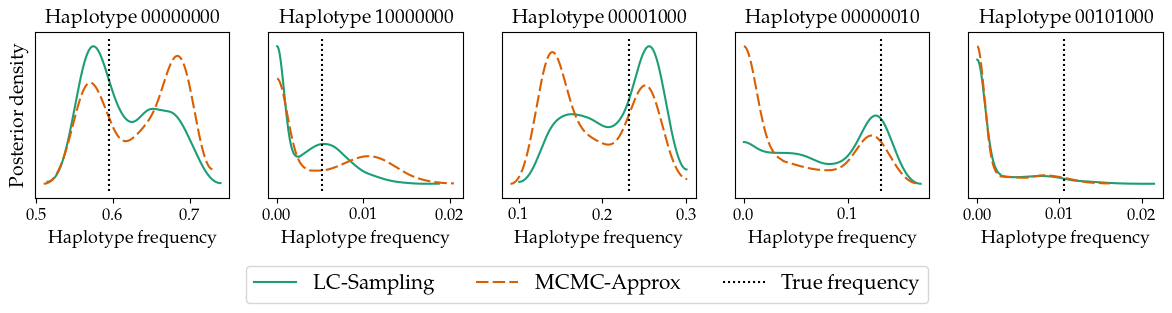

In [22]:
i = 2
subset = [7,2,4,5,13]
hstrs = [num_to_str(haps_list[i][x], 8) for x in subset]
ptrue = ptrue_list[i]

idata_cgibbs = az.from_netcdf(f'../../data/encode/psize50_m8_id{i+1}_cgibbs.netcdf')
postp_cgibbs = np.vstack(idata_cgibbs.posterior.p)

idata_mn = az.from_netcdf(f'../../data/encode/psize50_m8_id{i+1}_mn_approx.netcdf')
postp_mn = np.vstack(idata_mn.posterior.p)

fig, axes = plt.subplots(ncols=len(hstrs), figsize=(12, 3.2))
for j in range(len(hstrs)):
    ax = axes[j]
    # az.plot_kde(pred_samples_t10[:,j], ax=ax)
    grid, dens = az.stats.density_utils.kde(postp_cgibbs[:,subset[j]], bw='scott')
    ax.plot(grid, dens, color=colors[0], label='LC-Sampling');

    grid, dens = az.stats.density_utils.kde(postp_mn[:,subset[j]], bw='scott')
    ax.plot(grid, dens, '--', color=colors[1], label='MCMC-Approx', dashes=(6, 2));   
    
    ax.plot([ptrue.get(hstrs[j], 0)]*2, ax.get_ylim(), color='k', label='True frequency', linestyle=(0, (1, 1.4)))
    # for k in range(1, len(diffs)):
    #     if diffs[k] < 0 and diffs[k-1] > 0:
    #         ax.scatter(grid[k], dens[k], s=10, color='k', alpha=0.5)
    # ax.plot([ptrue.get(hstrs[j], 0)]*2, [0,ax.get_ylim()[1]*0.9], '--', color='k', alpha=0.5)
    ax.set_title(f'Haplotype {hstrs[j]}', fontsize=14)
    ax.set_xlabel('Haplotype frequency', fontsize=13)
    ax.set_yticks([])
    if j == 0:
        ax.set_ylabel('Posterior density', fontsize=14)
    ax.tick_params(axis='both', which='both', labelsize=12)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncols=len(labels), bbox_to_anchor=(0.5, 0.0), fontsize=15)
plt.subplots_adjust(top=0.88, left=0.04, right=0.98, bottom=0.36);
plt.savefig('kgenomes_multimodal.png', dpi=200, facecolor='white');

In [23]:
idata_hippo = az.from_netcdf(f'../../data/encode/psize50_m8_id{i+1}_hippo.netcdf')

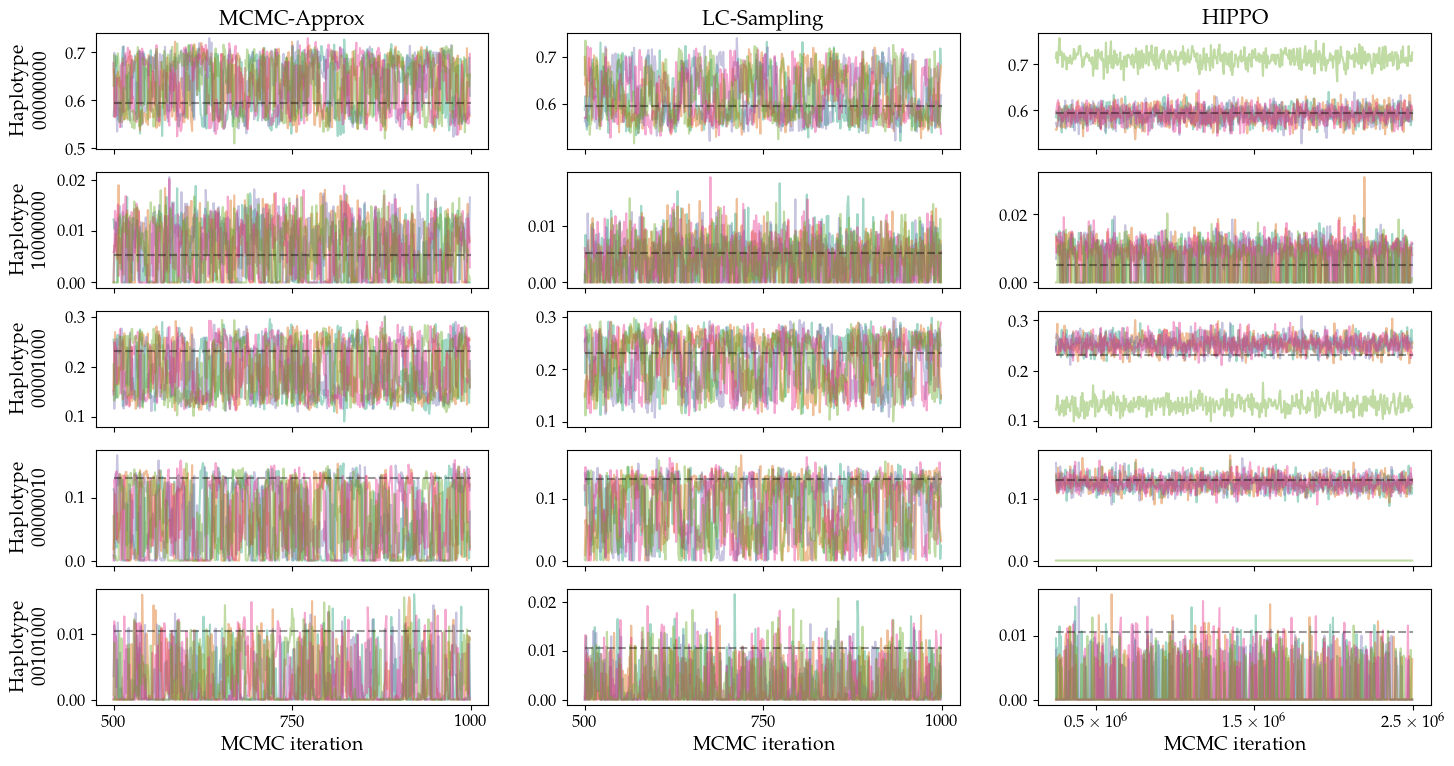

In [24]:
fig, axes = plt.subplots(nrows=len(hstrs), ncols=3, figsize=(15, 8))
for j in range(len(hstrs)):
    for c in range(5):
        axes[j,0].plot(idata_mn.posterior.p[c,:,subset[j]], color=colors[c], alpha=0.4)
        axes[j,1].plot(idata_cgibbs.posterior.p[c,:,subset[j]], color=colors[c], alpha=0.4)
        axes[j,2].plot(idata_hippo.posterior.p[c,:,str_to_num(hstrs[j])], color=colors[c], alpha=0.4)
    for k in range(3):
        axes[j,k].plot([0,500], [ptrue.get(hstrs[j], 0)]*2, '--', color='k', alpha=0.4)
        axes[j,k].tick_params(axis='both', which='both', labelsize=12)
        if j == len(hstrs)-1:            
            axes[j,k].set_xlabel('MCMC iteration', fontsize=14)
        if k == 2:
            tlocs = (np.array([0.5,1.5,2.5])-0.25)*10**6/4500
            tlabs = [r'$0.5\times 10^6$', r'$1.5\times 10^6$', r'$2.5\times 10^6$'] if j == len(hstrs)-1 else ['']*3
        else:
            tlocs = [0,250,500]
            tlabs = [500,750,1000] if j == len(hstrs)-1  else ['']*3
        axes[j,k].set_xticks(tlocs, tlabs)
    axes[j,0].set_ylabel(f'Haplotype\n {hstrs[j]}', fontsize=14)

axes[0,0].set_title('MCMC-Approx', fontsize=15);
axes[0,1].set_title('LC-Sampling', fontsize=15);
axes[0,2].set_title('HIPPO', fontsize=15);
    
fig.align_ylabels(axes[:,0])
    
plt.subplots_adjust(top=0.94, left=0.08, right=0.97, bottom=0.1);
plt.savefig('kgenomes_traces.png', dpi=200, facecolor='white');

In [25]:
# LC-Sampling ESS for this example
az.ess(idata_cgibbs.posterior, var_names=['p'])['p'].values[subset]

array([ 540.73591646, 1891.86310789,  529.06134938,  515.36019261,
       1752.52176435])

In [26]:
# MCMC-Approx ESS for this example
az.ess(idata_mn.posterior, var_names=['p'])['p'].values[subset]

array([557.8363912 , 477.23676761, 577.52042785, 370.57309975,
       402.61816356])

In [27]:
# HIPPO ESS for this example
az.ess(idata_hippo.posterior, var_names=['p'])['p'].values[[str_to_num(hstr) for hstr in hstrs]]

array([  10.13002236,   74.74313229,   10.13166564,   10.36433306,
       2423.57474166])